<a href="https://colab.research.google.com/github/MarcosLaydner/ds_repo/blob/master/Lab_8/TransferLearning_Exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone this repository to bring data to your virtual machine
!git clone https://github.com/sagihaider/CE888_2020.git

Cloning into 'CE888_2020'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 25146 (delta 28), reused 4 (delta 0), pack-reused 25082
Receiving objects: 100% (25146/25146), 561.99 MiB | 37.84 MiB/s, done.
Resolving deltas: 100% (64/64), done.


In [2]:
# Unzip the data from the zipped file
from zipfile import ZipFile
file_name = "/content/CE888_2020/Lab_8/data.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


In [3]:
!pip install tensorflow==1.3.0
!pip install keras==2.0.7

     |████████████████████████████████| 43.6MB 59kB/s 
     |████████████████████████████████| 1.6MB 52.2MB/s 
     |████████████████████████████████| 890kB 51.9MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107220 sha256=9f75f68126aeb5dae3606db047126255c73586c5a18f544cabc5bf0acaf70c1e
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: stable-baselines 2.2.1 has requirement tensorflow>=1.5.0, but you'll have tensorflow 1.3.0 which is incompatible.
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.3.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0
  Found existing installation: tensorflow 1.15.0
    Uninst

In [4]:

import numpy as np
import os
import time
from CE888_2020.Lab_8.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.layers import Dense, Activation, Flatten
from keras.layers import merge, Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarn

In [5]:
img_path = '/content/CE888_2020/Lab_8/elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
print (x.shape)
x = np.expand_dims(x, axis=0)
print (x.shape)
x = preprocess_input(x)
print('Input image shape:', x.shape)


(224, 224, 3)
(1, 224, 224, 3)
Input image shape: (1, 224, 224, 3)


In [6]:
import os
os.environ['KAGGLE_USERNAME'] = "marcoslaydner" # username from the json file
os.environ['KAGGLE_KEY'] = "3eee1608b13c9763a9cd3b36eea4b16c" # key from the json file
!kaggle competitions download -c dogs-vs-cats # api copied from kaggle

from zipfile import ZipFile

file_name = "/content/train.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

data_dir_list = os.listdir('/content/train')
#print(data_dir_list)

 98% 535M/543M [00:05<00:00, 101MB/s]
100% 543M/543M [00:05<00:00, 95.6MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 52.8MB/s]
 96% 259M/271M [00:02<00:00, 106MB/s] 
100% 271M/271M [00:02<00:00, 98.1MB/s]
done


In [7]:
path, dirs, files = next(os.walk("/content/train"))
file_count = len(files)
print(file_count)

original_dataset_dir = '/content/train'
base_dir = '/content/cats_and_dogs_small'
if os.path.isdir(base_dir):
  print('directory already exists')
else:
  os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
if os.path.isdir(train_dir):
  print('directory already exists')
else:
  os.mkdir(train_dir)

validation_dir = os.path.join(base_dir, 'validation')
if os.path.isdir(validation_dir):
  print('directory already exists')
else:
  os.mkdir(validation_dir)

test_dir = os.path.join(base_dir, 'test')
if os.path.isdir(test_dir):
  print('directory already exists')
else:
  os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
if os.path.isdir(train_cats_dir):
  print('directory already exists')
else:
  os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
if os.path.isdir(train_dogs_dir):
  print('directory already exists')
else:
  os.mkdir(train_dogs_dir)

# validation_cats_dir = os.path.join(validation_dir, 'cats')
# if os.path.isdir(validation_cats_dir):
#   print('directory already exists')
# else:
#   os.mkdir(validation_cats_dir)

# validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# if os.path.isdir(validation_dogs_dir):
#   print('directory already exists')
# else:
#   os.mkdir(validation_dogs_dir)

# test_cats_dir = os.path.join(test_dir, 'cats')
# os.mkdir(test_cats_dir)

# test_dogs_dir = os.path.join(test_dir, 'dogs')
# os.mkdir(test_dogs_dir)

25000


In [0]:
import shutil
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    #print(src,dst)
    shutil.copyfile(src, dst)
    
# fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(validation_cats_dir, fname)
#     shutil.copyfile(src, dst)

# fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_cats_dir, fname)
#     shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)

# fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(validation_dogs_dir, fname)
#     shutil.copyfile(src, dst)

# fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
# for fname in fnames:
#     src = os.path.join(original_dataset_dir, fname)
#     dst = os.path.join(test_dogs_dir, fname)
#     shutil.copyfile(src, dst)

In [0]:
#%% Loading the training data
PATH = os.getcwd()
# Define data path
data_path = train_dir
data_dir_list = os.listdir(train_dir)

In [10]:
img_data_list=[] # created an empty list for images to be loaded

for dataset in data_dir_list:
	img_list=os.listdir(train_dir+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		# print('Input image shape:', x.shape)
		img_data_list.append(x)

#%% 
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

Loaded the images of dataset-cats

Loaded the images of dataset-dogs

(2000, 1, 224, 224, 3)
(1, 2000, 224, 224, 3)
(2000, 224, 224, 3)


In [11]:
# Define the number of classes
num_classes = 2
print(img_data.shape[0])
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

# labels[0:202]=0
# labels[202:404]=1
# labels[404:606]=2
# labels[606:]=3

names = ['cats','dogs','horses','humans']

# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


2000


In [12]:
#%% Fine Tuning

image_input = Input(shape=(224, 224, 3))

model = VGG16(input_tensor=image_input, include_top=True,weights='imagenet')

model.summary()

551845888/553467096 [============================>.] - ETA: 0s_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (M

In [13]:
last_layer = model.get_layer('block5_pool').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(128, activation='relu', name='fc2')(x)
out = Dense(num_classes, activation='softmax', name='output')(x)
custom_vgg_model2 = Model(image_input, out)
custom_vgg_model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [14]:
# freeze all the layers except the dense layers
for layer in custom_vgg_model2.layers[:-3]:
	layer.trainable = False

custom_vgg_model2.summary()

custom_vgg_model2.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [15]:
t=time.time()
#	t = now()
hist = custom_vgg_model2.fit(X_train, y_train, batch_size=32, epochs=2, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_vgg_model2.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Train on 1600 samples, validate on 400 samples
Epoch 1/4
1600/1600 [==============================] - 2923s - loss: 0.0314 - acc: 0.9944 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 2/4
1600/1600 [==============================] - 2837s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 3/4
1600/1600 [==============================] - 2830s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Epoch 4/4
1600/1600 [==============================] - 2859s - loss: 1.1921e-07 - acc: 1.0000 - val_loss: 1.1921e-07 - val_acc: 1.0000
Training time: -11450.73485326767
400/400 [==============================] - 575s    
[INFO] loss=0.0000, accuracy: 100.0000%


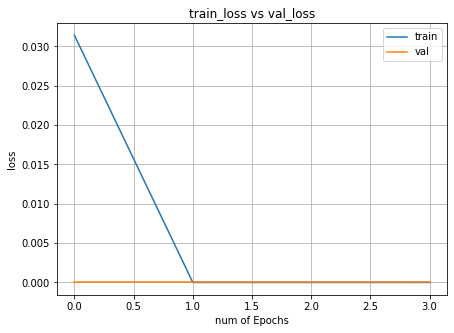

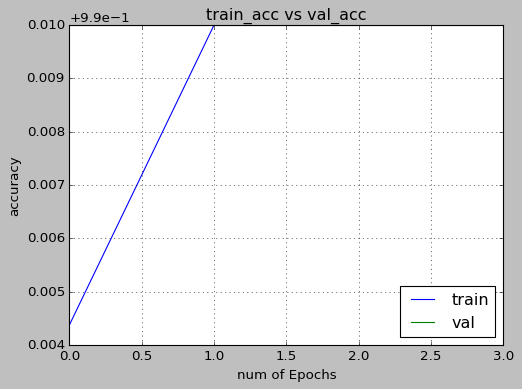

In [16]:
#%% plot
import matplotlib.pyplot as plt
# visualizing losses and accuracy
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['acc']
val_acc=hist.history['val_acc']
xc=range(4)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])